In [1]:
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusDelegationMechanism,
    StudentExpertDelegationMechanism,
)
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
)
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
import numpy as np
import matplotlib as mpl
import seaborn as sns

/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

In [2]:
batch_size = 128
window_size = 50
num_trials = 3
n_voters = 10


# Set up the Class Incremental framework
data = Data(
    data_set_name="mnist",
    # train_digit_groups=[range(5), range(5, 10)],
    # train_digit_groups=[[0, 1, 2], [3, 4, 5,], [6, 7, 8, 9]],
    train_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
    # test_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
    # test_digit_groups=[range(5), range(5, 10)],
    test_digit_groups=[range(10)],
    batch_size=batch_size,
)

# Single Active Voter

In [ ]:
# Create Delegation Mechanisms - single guru
max_active_gurus = 1

NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)

# create several mechanisms with a single active voter
random_better = ProbaSlopeDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    max_active=max_active_gurus,
    probability_function="random_better"
)
probabilistic_better = ProbaSlopeDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    max_active=max_active_gurus,
    probability_function="probabilistic_better"
)
probabilistic_weighted = ProbaSlopeDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    max_active=max_active_gurus,
    probability_function="probabilistic_weighted"
)
student_expert_del_mech = StudentExpertDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size
)
restricted_max_gurus_mech = RestrictedMaxGurusDelegationMechanism(
    batch_size=batch_size,
    num_voters=n_voters,
    max_active_voters=max_active_gurus,
    window_size=window_size,
    t_between_delegation=3,
)
UCB_del_mech = UCBDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    ucb_window_size=None
)

In [ ]:
# Create Ensembles - single guru


pretrained_ensemble = PretrainedEnsemble(
    n_voters=n_voters,
    delegation_mechanism=UCB_del_mech,
    name="UCB_delegation_ensemble"
    )
pretrained_ensemble.do_pretaining(data)

ensembles_dict = {
    "full_ensemble":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=NOOP_del_mech,
        name="full_ensemble",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "random_better_delegations":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=random_better,
        name="random_better_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "probabilistic_better_delegations":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=probabilistic_better,
        name="probabilistic_better_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "probabilistic_weighted_delegations":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=probabilistic_weighted,
        name="probabilistic_weighted_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    # "student_expert_delegations":
    # StudentExpertEnsemble(
    #     training_epochs=1,
    #     n_voters=n_voters,
    #     delegation_mechanism=student_expert_del_mech,
    #     name="student_expert_ensemble",
    #     input_dim=28 * 28,
    #     output_dim=10,
    # ),
    "restricted_max_gurus":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=restricted_max_gurus_mech,
        name="restricted_max_gurus",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "UCB_delegation_ensemble": pretrained_ensemble
}


In [3]:
# Train ensembles - single guru

one_active_exp = Experiment(n_trials=num_trials, ensembles=list(ensembles_dict.values()), data=data, seed=4090)
_ = one_active_exp.run()

100%|██████████| 10/10 [03:25<00:00, 20.55s/it]


In [8]:
# Print results - single guru

print(f"Results for mechanisms with max_active_gurus = {max_active_gurus}:")

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(
        one_active_exp, ens_name, num_trials
    )
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}")
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")
    
print("--------------")

# Collect and print test accuracies
results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    test_acc, test_acc_std = calculate_avg_std_test_accs(
        one_active_exp, ens_name, num_trials
    )
    results_dict[ens_name] = (test_acc, test_acc_std)

for ens_name, (test_acc, test_acc_std) in results_dict.items():
    print(f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}")


Results for mechanisms with max_active_gurus = 1:
Mean train acc for full_ensemble: 0.818+-0.036
Mean train acc for random_better_delegations: 0.827+-0.092
Mean train acc for probabilistic_better_delegations: 0.843+-0.066
Mean train acc for probabilistic_weighted_delegations: 0.846+-0.062
Mean train acc for student_expert_ensemble: 0.73+-0.092
Mean train acc for UCB_delegation_ensemble: 0.2+-0.373
--------------
Mean test acc for full_ensemble: 0.19+-0.003
Mean test acc for random_better_delegations: 0.293+-0.071
Mean test acc for probabilistic_better_delegations: 0.283+-0.057
Mean test acc for probabilistic_weighted_delegations: 0.243+-0.054
Mean test acc for student_expert_ensemble: 0.142+-0.045
Mean test acc for UCB_delegation_ensemble: 0.198+-0.033


# Many Active Voters

In [ ]:
# Create Delegation Mechanisms - multiple gurus
max_active_gurus = 3

NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)

# create several mechanisms with a single active voter
random_better = ProbaSlopeDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    max_active=max_active_gurus,
    probability_function="random_better"
)
probabilistic_better = ProbaSlopeDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    max_active=max_active_gurus,
    probability_function="probabilistic_better"
)
probabilistic_weighted = ProbaSlopeDelegationMechanism(
    batch_size=batch_size,
    window_size=window_size,
    max_active=max_active_gurus,
    probability_function="probabilistic_weighted"
)
# student_expert_del_mech = StudentExpertDelegationMechanism(
#     batch_size=batch_size,
#     window_size=window_size
# )
restricted_max_gurus_mech = RestrictedMaxGurusDelegationMechanism(
    batch_size=batch_size,
    num_voters=n_voters,
    max_active_voters=max_active_gurus,
    window_size=window_size,
    t_between_delegation=3,
)
# UCB_del_mech = UCBDelegationMechanism(
#     batch_size=batch_size,
#     window_size=window_size,
#     ucb_window_size=None
# )

In [ ]:
# Create Ensembles - many gurus


# pretrained_ensemble = PretrainedEnsemble(
#     n_voters=n_voters,
#     delegation_mechanism=UCB_del_mech,
#     name="UCB_delegation_ensemble"
#     )
# pretrained_ensemble.do_pretaining(data)

many_active_ensembles_dict = {
    "full_ensemble":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=NOOP_del_mech,
        name="full_ensemble",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "random_better_delegations":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=random_better,
        name="random_better_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "probabilistic_better_delegations":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=probabilistic_better,
        name="probabilistic_better_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    "probabilistic_weighted_delegations":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=probabilistic_weighted,
        name="probabilistic_weighted_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    # "student_expert_delegations":
    # StudentExpertEnsemble(
    #     training_epochs=1,
    #     n_voters=n_voters,
    #     delegation_mechanism=student_expert_del_mech,
    #     name="student_expert_ensemble",
    #     input_dim=28 * 28,
    #     output_dim=10,
    # ),
    "restricted_max_gurus":
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=restricted_max_gurus_mech,
        name="restricted_max_gurus",
        input_dim=28 * 28,
        output_dim=10,
    ),
    # "UCB_delegation_ensemble": pretrained_ensemble
}


In [ ]:
# Run experiment - Many gurus

many_active_exp = Experiment(n_trials=num_trials, ensembles=list(many_active_ensembles_dict.values()), data=data, seed=4090)
_ = many_active_exp.run()

100%|██████████| 10/10 [03:26<00:00, 20.68s/it]


In [ ]:
print(f"Results for mechanisms with max_active_gurus = {max_active_gurus}:")

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in many_active_ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(
        many_active_exp, ens_name, num_trials
    )
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}")
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")
    
print("--------------")

# Collect and print test accuracies
results_dict = dict()
for ens_name, ensemble in many_active_ensembles_dict.items():
    test_acc, test_acc_std = calculate_avg_std_test_accs(
        many_active_exp, ens_name, num_trials
    )
    results_dict[ens_name] = (test_acc, test_acc_std)

for ens_name, (test_acc, test_acc_std) in results_dict.items():
    print(f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}")


Results for mechanisms with max_active_gurus = 3:
Mean train acc for full_ensemble: 0.816+-0.034
Mean train acc for random_better_delegations: 0.87+-0.035
Mean train acc for probabilistic_better_delegations: 0.875+-0.03
Mean train acc for probabilistic_weighted_delegations: 0.874+-0.032
--------------
Mean test acc for full_ensemble: 0.189+-0.003
Mean test acc for random_better_delegations: 0.312+-0.034
Mean test acc for probabilistic_better_delegations: 0.282+-0.024
Mean test acc for probabilistic_weighted_delegations: 0.312+-0.031


# Explore Results

(leftover copied code from other file, not adapted for the above code)

NameError: name 'full_avg_test_accs' is not defined

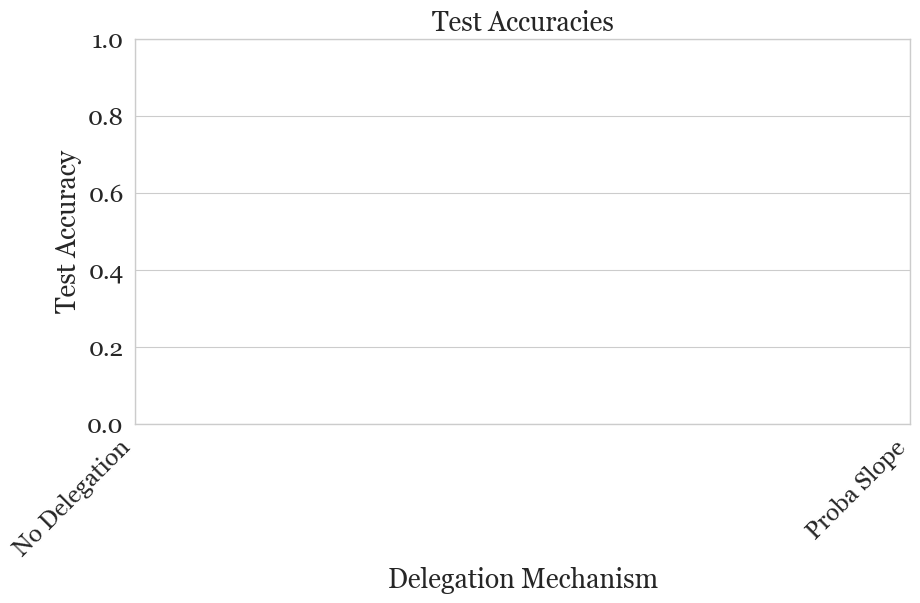

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1])
ax.set_xticklabels(["No Delegation", "Proba Slope"], rotation=45, ha="right")
# Data for bar plot
means = [
    np.mean(full_avg_test_accs),
    np.mean(proba_slope_avg_test_accs),
    # np.mean(restricted_max_guru_avg_test_accs),
]
stds = [
    np.std(full_avg_test_accs),
    np.std(proba_slope_avg_test_accs),
    # np.std(restricted_max_guru_avg_test_accs),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [ ]:
proba_slope_avg_train_accs, proba_slope_std_train_accs = calculate_avg_std_train_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

# (
#     restricted_max_guru_avg_train_accs,
#     restricted_max_guru_std_train_accs,
# ) = calculate_avg_std_train_accs(exp, "restricted_max_guru_delegations", num_trials)

print(
    "Mean train accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

# print(
#     "Mean train accs for restricted_max_guru delegation ensemble: ",
#     np.mean(restricted_max_guru_avg_train_accs),
# )

Mean train accs for proba_slope delegation ensemble:  0.8517013148585362
Mean train accs for full ensemble:  0.803889592217484


In [ ]:
train_splits = exp.train_splits

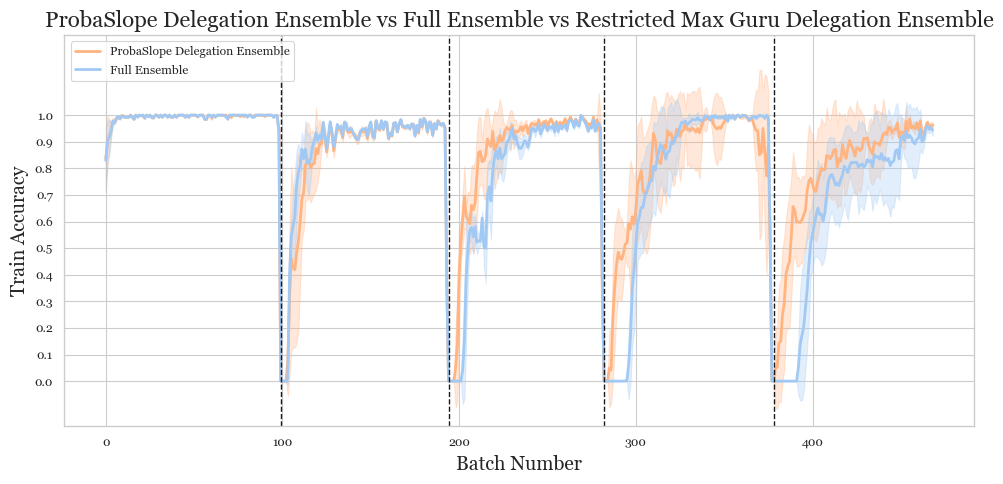

In [ ]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="ProbaSlope Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "ProbaSlope Delegation Ensemble vs Full Ensemble vs Restricted Max Guru Delegation Ensemble"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ps_voters = exp.ensembles[1].voters
print(ensembles[1].name)
batch_accs = []
for v in ps_voters:
    batch_accs.append(v.batch_accuracies)

proba_slope_delegations


In [ ]:
len_train = len(data.train_data_loader.dataset) / batch_size

In [ ]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["proba_slope_delegations"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

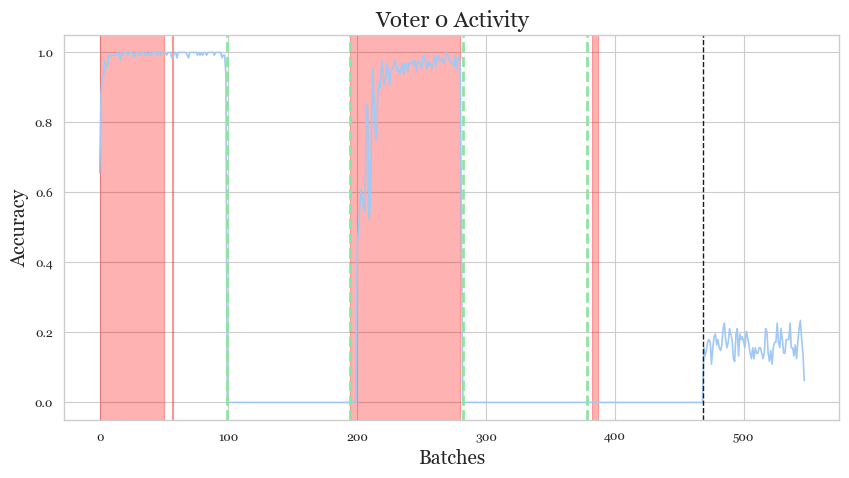

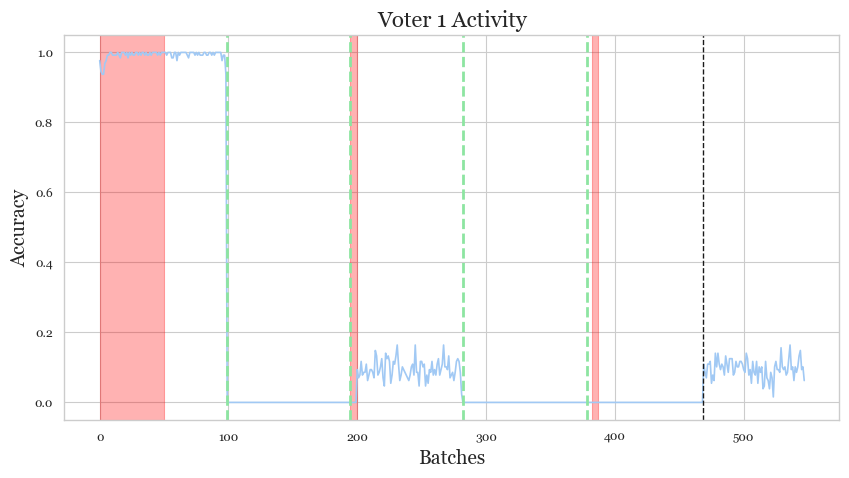

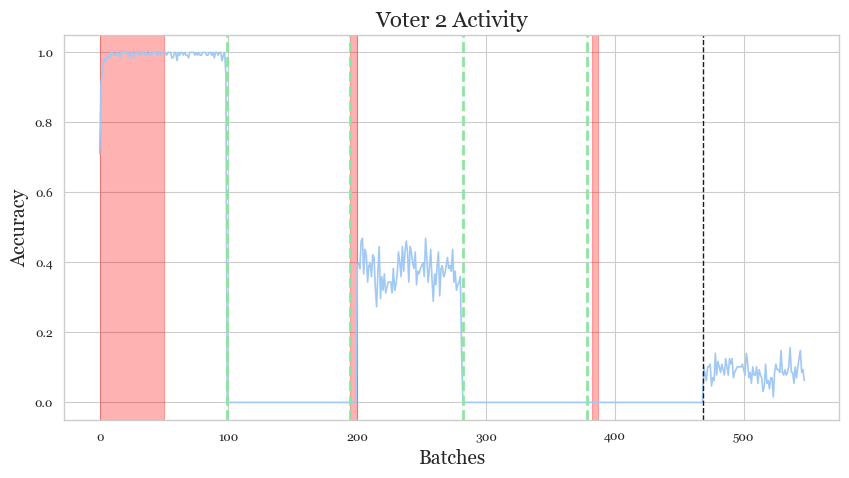

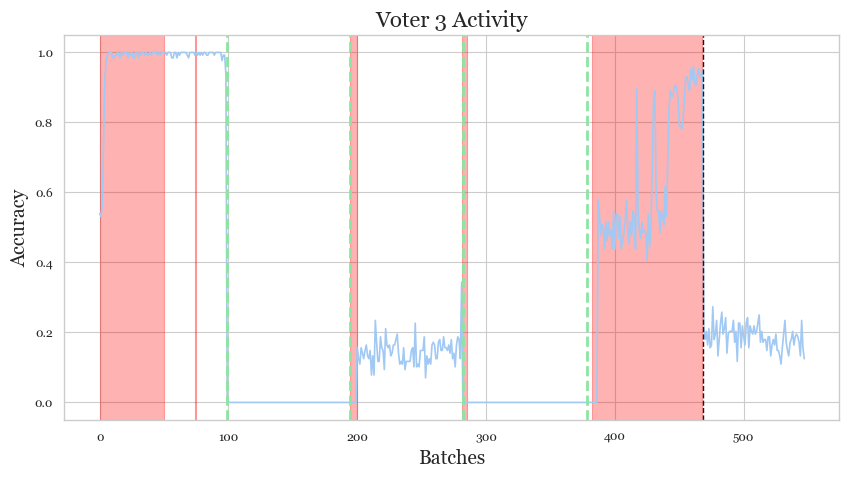

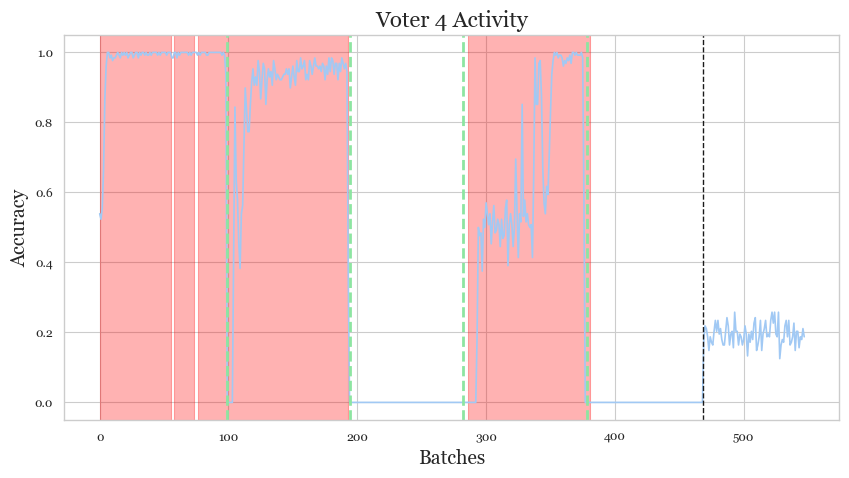

In [ ]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter